This module draws heavily from and modifies [Introduction to Pandas](https://github.com/fonnesbeck/statistical-analysis-python-tutorial) by Chris Fonnesbeck, which is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Pandas

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
import pandas as pd
import numpy as np
from IPython.display import display

## Data structures

In [3]:
# Series, indexes
concs = pd.Series([1.1, 2.3, 1.2, 3.5],)
concs.values
concs.index

# Explicit indices
concs = pd.Series([1.1, 2.3, 1.2, 3.5],
                  index = ["CO2", "CH4", "NO2", "O3"])

# Accessing elements of series
concs.CO2 # attribute
concs['CH4'] # key
["O" in formula for formula in concs.index] # looping
concs[0] # positional indexing

# Naming the indices, the values
concs.name = "concentrations (ppb)"
concs.index.name = "compound"

# Numpy-like behavior
concs[0:2]
concs + concs
np.log(concs)
concs[concs > 2]

# Are these the same?  Think about how to ask this.
slice1 = concs["CO2":"NO2"]
slice2 = concs[0:2]
# Inclusive endpoints when slicing using indices

# Construction using dictionaries, Note sorting
concs_dict = {"CO2": 1.1, "CH4": 2.3, 
              "NO2": 1.2, "O3": 3.5}
concs = pd.Series(concs_dict)

# Specifying indices, NaN, alignment of dissimilar series
concs2 = pd.Series(concs_dict, index=["CO2", "CH4", "NO2", "H2O"])
concs2.isnull()
concs + concs2

CH4    4.6
CO2    2.2
H2O    NaN
NO2    2.4
O3     NaN
dtype: float64

In [4]:
# DataFrames - Tabular data structures
atmo = pd.DataFrame({"conc": [1.1, 2.3, 1.2, 3.5],
                     "weight":[44, 16, 46, 48],
                     "formula":["CO2", "CH4", "NO2", "O3"]})

# Indexes, columns
atmo.index # like row labels
atmo.columns

# accessing columns by key, attribute
atmo.weight
atmo['formula']
# diff from series, where index access via attribute/key

# Accessing rows, why are these two things different?
atmo.ix[0]
atmo.ix[0:1]
# Hint, use the type function

atmo.T
atmo.index = atmo.formula

## Real data

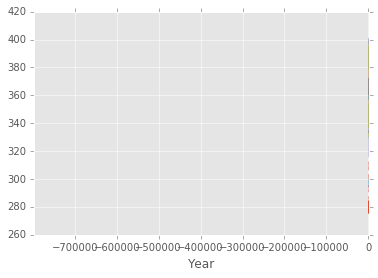

In [5]:
co2 = pd.read_csv("../data/atmo_CO2.csv")
co2 = pd.read_csv("../data/atmo_CO2.csv", index_col = "Year")

co2 = co2.drop("StanfordCalifornia", axis = 1)
# or
co2 = co2.dropna(axis = 1, how = "all")

#co2.info()
#co2.describe()

#co2.plot(legend = False)
co2.ix[:, co2.columns != "EPICADome"].plot(legend = False)

## Concatenation

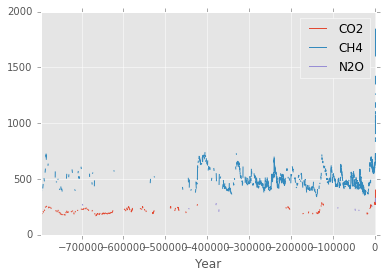

In [6]:
co2.mean(axis=1)
ch4 = pd.read_csv("../data/atmo_CH4.csv", index_col = "Year")
n2o = pd.read_csv("../data/atmo_N2O.csv", index_col = "Year")

# Concat
summary = pd.concat([chem.mean(axis=1) for chem in [co2, ch4, n2o]], axis=1)
summary.columns = ["CO2", "CH4", "N2O"]
summary.plot()

## Fill in missing data

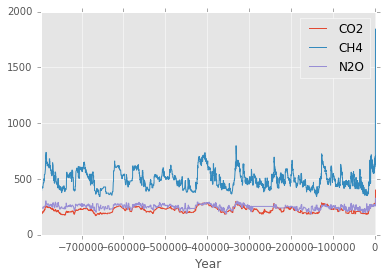

In [7]:
summary = summary.fillna(method = "bfill")
summary.plot()

## Writing to file

In [8]:
summary.to_csv("atmo_summary.csv")

## Statistics and correlations

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d936828>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11dc281d0>], dtype=object)

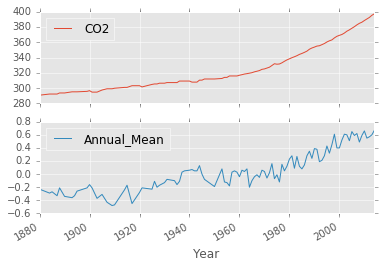

In [149]:
temp = pd.read_csv("../data/temperature.csv", index_col = "Year")
temp.index = temp.index.astype(float)
temp_comp = pd.concat((summary, temp["Annual_Mean"]), axis = 1)
temp_comp = temp_comp.dropna()
temp_comp[["CO2", "Annual_Mean"]].plot(subplots=True)

In [150]:
temp_comp.corr()

,CO2,CH4,N2O,Annual_Mean
CO2,1.000000,0.962322,0.997721,0.936630
CH4,0.962322,1.000000,0.970145,0.907395
N2O,0.997721,0.970145,1.000000,0.936295
Annual_Mean,0.936630,0.907395,0.936295,1.000000


In [135]:
temp_comp.cov()

,CO2,CH4,N2O,Annual_Mean
CO2,1080.873337,4161.800411,445.496966,8.440250
CH4,4161.800411,25209.716683,2009.876562,93.621222
N2O,445.496966,2009.876562,397.120965,4.061114
Annual_Mean,8.440250,93.621222,4.061114,0.090383


In [151]:
model = pd.ols(y = temp_comp["Annual_Mean"], x = temp_comp["CO2"])
print(model.summary)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         103
Number of Degrees of Freedom:   2

R-squared:         0.8773
Adj R-squared:     0.8761

Rmse:              0.1064

F-stat (1, 101):   721.9861, p-value:     0.0000

Degrees of Freedom: model 1, resid 101

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0095     0.0004      26.87     0.0000     0.0088     0.0102
     intercept    -3.0601     0.1167     -26.22     0.0000    -3.2888    -2.8314
---------------------------------End of Summary---------------------------------



/Users/josephmontoya/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


In [99]:
import statsmodels.api as sm
summary = summary.dropna()
xdata = summary.CO2.tolist()
xdata = sm.add_constant(xdata)
#xdata = sm.add_constant(xdata)
ydata = summary.N2O.tolist()
model = sm.OLS(ydata, xdata).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     3797.
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        21:55:24   Log-Likelihood:                -18113.
No. Observations:                4417   AIC:                         3.623e+04
Df Residuals:                    4415   BIC:                         3.624e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        157.2090      1.596     98.503      0.000       154.080   160.338
x1             0.4122      0.007     61.620      0.000         0.399     0.425
==============================================================================
Omnibus:                        6.262   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.625
Skew:                           0.055   Prob(JB):                       0.0364
Kurtosis:                       3.155   Cond. No.                     1.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

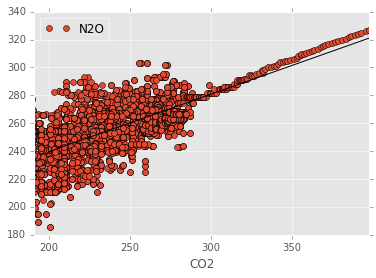

In [100]:
summary.plot(y = "N2O", x = "CO2", linestyle = '', marker = 'o')
xmodel = np.linspace(200, 400)
ymodel = 0.4122 * xmodel + 157.2090
plt.plot(xmodel, ymodel, 'k-')

## Exercise: Do a OLS regression on a 3-parameter quadratic model

In [101]:
xsquared = xdata[:, 1]**2

xdata = np.concatenate((xdata, xsquared.reshape(4417, 1)), axis = 1)
model = sm.OLS(ydata, xdata).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     1906.
Date:                Sun, 26 Jun 2016   Prob (F-statistic):               0.00
Time:                        21:56:52   Log-Likelihood:                -18108.
No. Observations:                4417   AIC:                         3.622e+04
Df Residuals:                    4414   BIC:                         3.624e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        135.2191      7.850     17.226      0.000       119.830   150.608
x1             0.5947      0.064      9.270      0.000         0.469     0.720
x2            -0.0004      0.000     -2.861      0.004        -0.001    -0.000
==============================================================================
Omnibus:                        6.234   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.442
Skew:                           0.064   Prob(JB):                       0.0399
Kurtosis:                       3.137   Cond. No.                     2.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

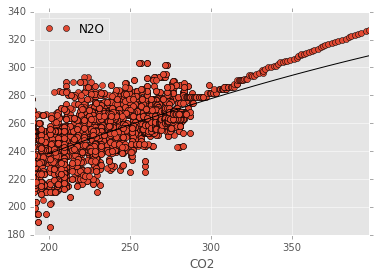

In [102]:
summary.plot(y = "N2O", x = "CO2", linestyle = '', marker = 'o')
xmodel = np.linspace(200, 400)
ymodel = -0.0004 * xmodel**2 + 0.5947 * xmodel + 135.2191
plt.plot(xmodel, ymodel, 'k-')